In [4]:
import sys
path ="/home/sergio/github/shaolin-master"
sys.path.append(path)

In [5]:
%%HTML
<style>
.container { width:100% !important; }
.input{ width:60% !important;
       align: center;
      }
.text_cell{ width:70% !important;
            font-size: 16px;}
.title {align:center !important;}
</style>

# Creating complex Dashboards

<a id='index'></a>

## Index

- [1 Introduction](#intro)
- [2 Defining the Dashboard parameters](#parameters)
- [3 Dashboard layout & inizialization](#dash_and_init)
    - [3.1 Layout with custom defaults](#custom_defaults)
    - [3.2 ArrayScaler init function](#init)
- [4 Scaler functionality](#functionality)
- [5 Plotting the ArraySlicer output](#plot)  
    - [5.1 Layered approach](#layered)
    - [5.2 Single Dashboard approach](#single)

<a id='introduction'></a>

# 1 Introduction

In this tutorial we will show how it is possible to create complex dashboards for data analysis by inheriting from the Dashboard class. We will build a data scaler that will interact with a matplotlib plot to show how the data is modified.

The Dashboard that we are going to build has the following capabilities:
- Apply an arbitrary function to a numpy array selected fom a dict of available functions.
- Scale the data into an arbitrary range. This scaling will be optional and the data will be scaled before applying the selected function.
- Show how the data is being modified in real time.

<a id='parameters'></a>

# 2 Defining the Dashboard parameters

[Back to top](#index)

Our Dashboard will have the following parameters:
- **funcs**: A dictionary of available functions that the scaler can apply to the data. 
- **min**: minimum value for the scaling.
- **max**: maximum value fot the scaling.
- **step**: step parameter fot the scaler slider.
- **low**: initial lower bound for the scaling.
- **high**: initial higher bound for the scaling.
- **kwargs**: keyword arguments for the Dashboard.__init__ function like name, mode...

We will also define a nice set of initial parameters just in case we want to paly later with it without worrying about inizialization.

In [6]:
import numpy as np
from shaolin.core.dashboard import Dashboard
class ArrayScaler(Dashboard):
    
    def __init__(self,
                 data,
                 funcs=None,
                 min=-100.,
                 max=100.,
                 step=None,
                 low=None,
                 high=None,
                 **kwargs):
        if funcs is None:
            self.funcs = {'raw':lambda x: x,
                          'zscore': lambda x: (x-np.mean(x))/np.std(x),
                          'log': np.log,
                          'rank':lambda x: pd.DataFrame(x).rank().values.flatten(),
                          'abs': np.abs
                         }
        else:
            self.funcs  = funcs
        self._data = data
        if min is None:
            min = self._data.min().values[0]
        if max is None:
            max = self._data.max().values[0]
        if step is None:
            step = (max-min)/100.
        if low is None:
            low = min
        if high is None:
            high = max

<a id='dash_and_init'></a>

# 3 Dashboard layout & inizialization

[Back to top](#index)

<a id='custom_defaults'></a>

## 3.1 Layout with custom defaults

In this case we are going to use the same layout shown in the first Dasboard tutorial, but instead of hardcoding its component default values we will use the parameters of the former section. This way when we create an instance of an ArrayScaler we wont have to worry a obout its interface internals. 

In [ ]:
dash = ['c$N=df_scaler',
        ['@('+str(min)+', '+str(max)+', '+str(step)+', ('+str(low)+', '+str(high)+'))$N=scale_slider&d=Scale',
         ['r$N=main_row',['@dd$d=Apply&N=dd_sel&val=raw&o='+str(list(self.funcs.keys())),'@False$N=scale_chk&d=Scale']],
         ['html$N=plot']
        ]
       ]

<a id='init'></a>

## 3.2 ArrayScaler init function

[Back to top](#index)

Now we have defined the layout and parameters we can call the Dashboard.init function. Afther that we only have to bind the update function to achieve interactivity. We will also call the init function with the custom layout that we created in the former example. 

The data attribute has an underscore because later we are going to define the  as a property, so it the widget can be updated every time it changes its data.  

In [17]:
class ArrayScaler(Dashboard):
    
    def __init__(self,
                 data,
                 funcs=None,
                 min=-100.,
                 max=100.,
                 step=None,
                 low=None,
                 high=None,
                 **kwargs):
        if funcs is None:
            self.funcs = {'raw':lambda x: x,
                          'zscore': lambda x: (x-np.mean(x))/np.std(x),
                          'log': np.log,
                          'rank':lambda x: pd.DataFrame(x).rank().values.flatten(),
                          'abs': np.abs
                         }
        else:
            self.funcs  = funcs
        self._data = data
        if min is None:
            min = self._data.min().values[0]
        if max is None:
            max = self._data.max().values[0]
        if step is None:
            step = (max-min)/100.
        if low is None:
            low = min
        if high is None:
            high = max
        
        dash = ['c$N=array_scaler',
                ['@('+str(min)+', '+str(max)+', '+str(step)+', ('+str(low)+', '+str(high)+'))$N=scale_slider&d=Scale',
                 ['r$N=main_row',['@dd$d=Apply&N=dd_sel&val=raw&o='+str(list(self.funcs.keys())),'@False$N=scale_chk&d=Scale']],
                ]
               ]
        Dashboard.__init__(self, dash, mode='interactive',state='array_scaler.pkl', **kwargs)
        #self.observe(self.update)
        #self.update()

Thsi is how our graphic interface wil look

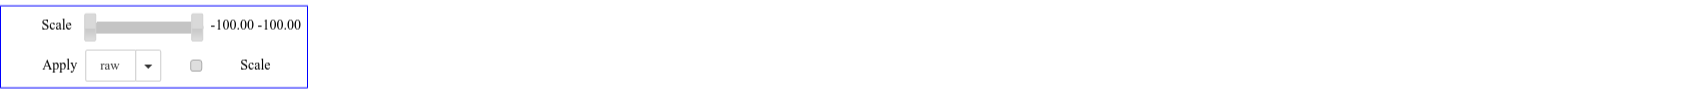

In [16]:
data = np.random.normal(size=(20))
asc = ArrayScaler(data)
asc.widget

<a id='functionality'></a>

# 4 Scaler functionality

[Back to top](#index)

Now its time to define the data wrangling capabilities of our Dashboard. Our ArrayScaler will have a function for scaling the data and an update function, that will calculate its output and will be called every time an interactive component changes its value.

In [19]:
def scale_func(self, data):
    Ma = np.max(data)
    mi = np.min(data)
    score = ((data-mi)/(Ma-mi))#to 0-1 interval
    if mi == Ma:
           return np.ones(len(score)) *0.5
    scale_h = self.scale_slider.value[1]
    scale_l = self.scale_slider.value[0]
    return score*(scale_h-scale_l)+scale_l

The undercored parameter of the update function is the *change* value os the observe function. As it will be rarely used I just define it like this, so it's possible to call the update function both as an observe call or as standalone function.

In [20]:
def update(self, _=None):
    if self.scale_chk.value:
        self.scale_slider.visible = True
        self.output = self.funcs[self.dd_sel.value](self.scale_func(self._data))
    else:
        self.scale_slider.visible = False
        self.output = self.funcs[self.dd_sel.value](self._data)

Now we have everything we need to modify the data. We will set the default mode of this Dashboard and then we have our ArrayScaler finished.

In [28]:
class ArrayScaler(Dashboard):
    
    def __init__(self,
                 data,
                 funcs=None,
                 min=-100.,
                 max=100.,
                 step=None,
                 low=None,
                 high=None,
                 mode='interactive',
                 **kwargs):
        if funcs is None:
            self.funcs = {'raw':lambda x: x,
                          'zscore': lambda x: (x-np.mean(x))/np.std(x),
                          'log': np.log,
                          'rank':lambda x: pd.DataFrame(x).rank().values.flatten(),
                          'abs': np.abs
                         }
        else:
            self.funcs  = funcs
        self._data = data
        if min is None:
            min = self._data.min().values[0]
        if max is None:
            max = self._data.max().values[0]
        if step is None:
            step = (max-min)/100.
        if low is None:
            low = min
        if high is None:
            high = max
        
        dash = ['c$N=array_scaler',
                ['@('+str(min)+', '+str(max)+', '+str(step)+', ('+str(low)+', '+str(high)+'))$N=scale_slider&d=Scale',
                 ['r$N=main_row',['@dd$d=Apply&N=dd_sel&val=raw&o='+str(list(self.funcs.keys())),'@False$N=scale_chk&d=Scale']],
                ]
               ]
        Dashboard.__init__(self, dash, state='array_scaler.pkl',mode=mode, **kwargs)
        self.observe(self.update)
        self.update()
    
    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, val):
        self._data = val
        self.update()
        
    def scale_func(self, data):
        Ma = np.max(data)
        mi = np.min(data)
        score = ((data-mi)/(Ma-mi))#to 0-1 interval
        if mi == Ma:
               return np.ones(len(score)) *0.5
        scale_h = self.scale_slider.value[1]
        scale_l = self.scale_slider.value[0]
        return score*(scale_h-scale_l)+scale_l
    
    def update(self, _=None):
        if self.scale_chk.value:
            self.scale_slider.visible = True
            self.output = self.funcs[self.dd_sel.value](self.scale_func(self._data))
        else:
            self.scale_slider.visible = False
            self.output = self.funcs[self.dd_sel.value](self._data)

In [32]:
arrs = ArrayScaler(data)

<a id='plot'></a>

# 5 Plotting the ArraySlicer output

[Back to top](#index)

<a id='layered'></a>

## 5.1 Layered approach

In order to see how we are modifying the data with our ArrayScaler we are going to build a Dashboard capable of displaying arbitrary matplotlib figures as an HTML widget created directly from the output of another Dashboard. 

In [59]:
class MatplotlibPlot(Dashboard):
    
    def __init__(self, data_dashboard, plot_func,width="45em", height="15em", **kwargs):
        self.plot_func = plot_func
        self._target_name = data_dashboard.name
        self._height = height
        self._width = width
        dashboard = ['c$N=mpl_plot',
                     [data_dashboard,
                      'html$N=plot'
                     ]
                    ]
        Dashboard.__init__(self, dashboard, mode='interactive', **kwargs)
        self.observe(self.update)
        self.update()

    def fig_to_html(self, fig, img_class=''):
        """This is a hack that converts a matplotlib like fig to an HTML image div"""
        from io import BytesIO
        import base64
        import warnings
        warnings.filterwarnings('ignore')
        imgdata = BytesIO()
        fig.savefig(imgdata, format='png',bbox_inches='tight',dpi=90, transparent=True)
        imgdata.seek(0)  # rewind the data
        svg_dta = imgdata.getvalue()
        svg_image = Image(svg_dta)#
        svg_b64 = base64.b64encode(svg_image.data).decode()
        self.plot.widget.layout.width = self._width
        self.plot.target.layout.width = "100%"
        self.plot.widget.layout.height = self._height
        self.plot.target.layout.height = "100%"
        height = self.plot.target.layout.height
        width = self.plot.target.layout.width
        return '<img class="cmap '+img_class+'" height="'+str(height)+'" width="'\
                +str(width)+'" src="data:image/png;base64,'+svg_b64+'" />'
    
    def update(self, _=None):
        fig, ax = self.plot_func(getattr(self,self._target_name).output)
        plt.close(fig)
        self.plot.value = self.fig_to_html(fig)

This Dashboard is really usefull for quickly generalizing any matplotlib plot and adapt it to any kind of data processing, but we will pay the cost of flexibility by having a higher response time than if we write the plotting logic alongside the data processing code(I suppose this is due to the internal structure of the ipywidgets package/jupyter notebook or even mabe browser related, but I don't don't see how this limitation can be easily overcomed). Below this example I have wirtten the same logic as a single Dashboard so you can compare the performance issues. Any help regarthing this topic will be much appreciated, as this package aimg to be able to link hundreds of widgets at the same time. 

In both cases we have response times below 1 second, but in the layered approach the lag is notticeable. 

In [54]:
import matplotlib.pyplot as plt
from IPython.display import Image
def plot(output):
    fig, ax = plt.subplots(figsize=(10, 1))
    plt.title('Output data')
    ax.plot(output)
    return fig, ax
test = MatplotlibPlot(arrs, plot)

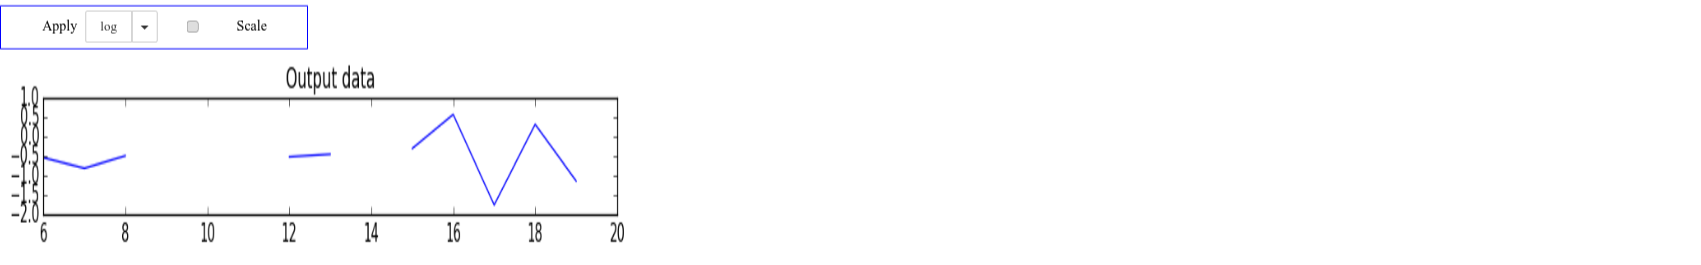

In [61]:
test.widget

<a id='single'></a>

## 5.2 Single Dashboard approach

[Back to top](#index)

In [60]:

class FullArrayScaler(Dashboard):
    
    def __init__(self,
                 data,
                 funcs=None,
                 min=-100.,
                 max=100.,
                 step=None,
                 low=None,
                 high=None,
                 **kwargs):
        if funcs is None:
            self.funcs = {'raw':lambda x: x,
                          'zscore': lambda x: (x-np.mean(x))/np.std(x),
                          'log': np.log,
                          'rank':lambda x: pd.DataFrame(x).rank().values.flatten(),
                          'abs': np.abs
                         }
        else:
            self.funcs  = funcs
        self._data = data
        if min is None:
            min = self._df.min().values[0]
        if max is None:
            max = self._df.max().values[0]
        if step is None:
            step = (max-min)/100.
        if low is None:
            low = min
        if high is None:
            high = max
        
        dash = ['c$N=df_scaler',
                ['@('+str(min)+', '+str(max)+', '+str(step)+', ('+str(low)+', '+str(high)+'))$N=scale_slider&d=Scale',
                 ['r$N=main_row',['@dd$d=Apply&N=dd_sel&val=raw&o='+str(list(self.funcs.keys())),'@False$N=scale_chk&d=Scale']],
                 ['html$N=plot']
                ]
               ]
        Dashboard.__init__(self, dash, mode='interactive', **kwargs)
        self.observe(self.update)
        self.update()
    
    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, val):
        self._data = val
        self.update()
    
    def scale_func(self, data):
        Ma = np.max(data)
        mi = np.min(data)
        score = ((data-mi)/(Ma-mi))#to 0-1 interval
        if mi == Ma:
               return np.ones(len(score)) *0.5
        scale_h = self.scale_slider.value[1]
        scale_l = self.scale_slider.value[0]
        return score*(scale_h-scale_l)+scale_l 
    
    def fig_to_html(self, fig, img_class=''):
        """This is a hack that converts a matplotlib like fig to an HTML image div"""
        from io import BytesIO
        import base64
        import warnings
        warnings.filterwarnings('ignore')
        imgdata = BytesIO()
        fig.savefig(imgdata, format='png',bbox_inches='tight',dpi=160, transparent=True)
        imgdata.seek(0)  # rewind the data
        svg_dta = imgdata.getvalue()
        svg_image = Image(svg_dta)#
        svg_b64 = base64.b64encode(svg_image.data).decode()
        self.plot.widget.layout.width ="45em"
        self.plot.target.layout.width = "100%"
        self.plot.widget.layout.height = "15em"
        self.plot.target.layout.height = "100%"
        height = self.plot.target.layout.height
        width = self.plot.target.layout.width
        return '<img class="cmap '+img_class+'" height="'+str(height)+'" width="'\
                +str(width)+'" src="data:image/png;base64,'+svg_b64+'" />'
    
    def update(self, _=None):
    
        if self.scale_chk.value:
            self.scale_slider.visible = True
            self.output = self.funcs[self.dd_sel.value](self.scale_func(self._data))
        else:
            self.scale_slider.visible = False
            self.output = self.funcs[self.dd_sel.value](self._data)
        fig, ax = plt.subplots(figsize=(10, 1))
        plt.title('Output data')
        ax.plot(self.output)
        plt.close(fig)
        self.plot.value = self.fig_to_html(fig)

In [57]:
version2 = FullArrayScaler(data)

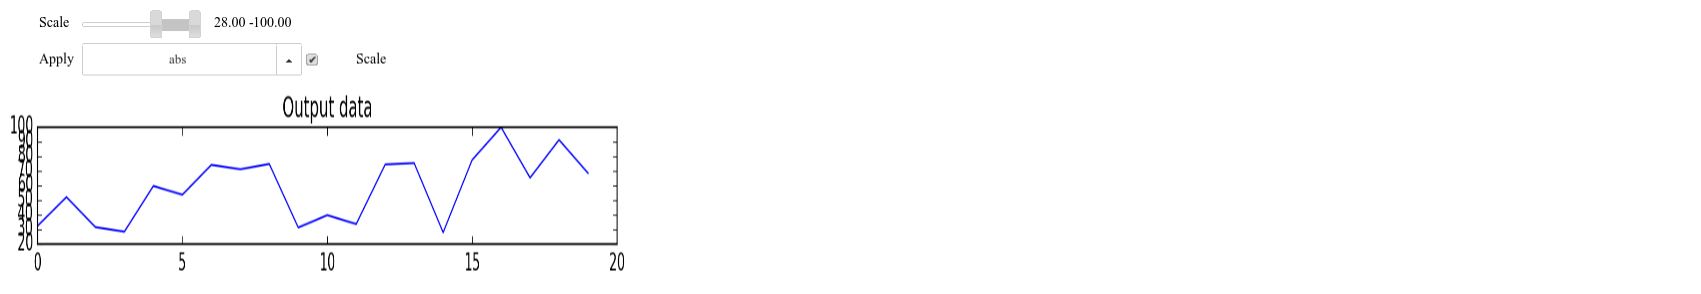

In [58]:
version2.widget